# Algorytmy macierzowe - zadanie nr 4 - Eliminacja Gaussa i Cholesky’ego dla macierzy rzadkich

2. Wierszowa rzadka eliminacja Choleskyego w formacie CSR

Marcin Hawryluk, Norbert Wolniak <br>grupa: piątek 12:50B <hr>

In [1]:
import numpy as np
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import os
from time import time
from read_matrix import read_matrix

## Generowanie macierzy

In [9]:
matrices  = []
for file in os.listdir('matrices'):
    matrices.append(read_matrix('matrices/' + file))

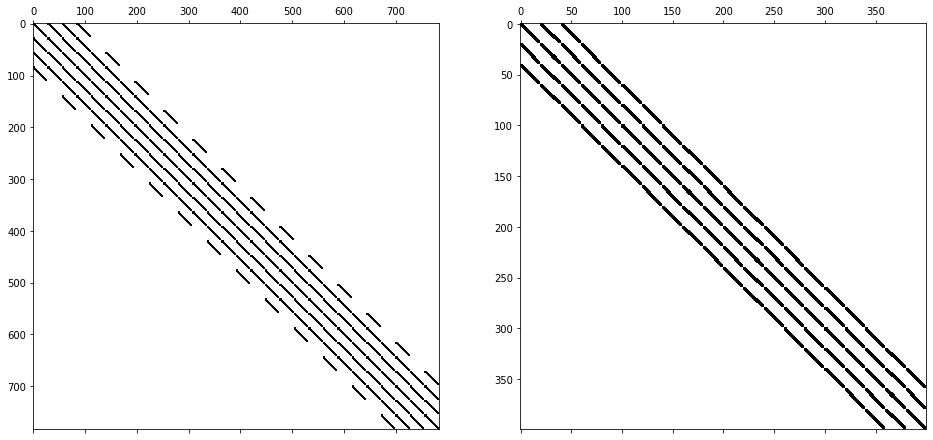

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].spy(matrices[0])
ax[1].spy(matrices[1])
plt.show()

## Eliminacja Cholesky'ego dla macierzy gęstych

// wybrać jedną wersję:

In [3]:
def cholesky_LDLT(matrix):
    A = matrix.copy()
    n = A.shape[0]
    
    for k in range(n):
        dkk = A[k, k]
        if abs(dkk) < 1e-8:
            raise ValueError('singular matrix')

        vk = A[k, k+1:].copy()
        A[k, k+1:] /= dkk
        A[k+1:n, k] /= dkk
      
        for j in range(k + 1, n):
            A[j, j:] -= A[k, j:] * vk[j-k-1]
            
    D = np.diag(A)*np.eye(n)
    
    return np.triu(A).T - D + np.eye(n), D 

In [76]:
def cholesky_LLT(matrix):
    A = matrix.copy()
    n = A.shape[0]
    
    for k in range(n):
        if abs(A[k, k]) < 1e-8:
            raise ValueError('singular matrix')
            
        vk = A[k, k+1:n]
        A[k, k] **= 0.5
        dkk = A[k, k]
        A[k, k+1:n] /= dkk
        
        
        for j in range(k+1, n):
            A[j, j:n] -= A[k, j:n]*vk[j-k-1]        
        
        print(A)
    return np.triu(A).T

In [52]:
matrix = np.array([[4, 4, 6], [4, 13, 15], [6, 15, 43]], dtype=float)
matrix

array([[ 4.,  4.,  6.],
       [ 4., 13., 15.],
       [ 6., 15., 43.]])

In [77]:
L = cholesky_LLT(matrix)

print("---L L.T---")

print("L:\n", L)
print("\nL.T:\n", L.T)
print("\nL*L.T:\n", L @ L.T)

print("\nnumpy L:\n")
print("", np.linalg.cholesky(matrix), "\n")

print("Correct!" if np.allclose(L @ L.T, matrix) else "wrong")

[[ 2.  2.  3.]
 [ 4.  9.  9.]
 [ 6. 15. 34.]]
[[ 2.  2.  3.]
 [ 4.  3.  3.]
 [ 6. 15. 25.]]
[[ 2.  2.  3.]
 [ 4.  3.  3.]
 [ 6. 15.  5.]]
---L L.T---
L:
 [[2. 0. 0.]
 [2. 3. 0.]
 [3. 3. 5.]]

L.T:
 [[2. 2. 3.]
 [0. 3. 3.]
 [0. 0. 5.]]

L*L.T:
 [[ 4.  4.  6.]
 [ 4. 13. 15.]
 [ 6. 15. 43.]]

numpy L:

 [[2. 0. 0.]
 [2. 3. 0.]
 [3. 3. 5.]] 

Correct!


In [30]:
L, D = cholesky_LDLT(matrix)

print("---L D L.T---")

print("L:\n", L)
print("\nD:\n", D)
print("\nL.T:\n", L.T)
print("\nL*D*L.T:\n", L @ D @ L.T)
print()
print("Correct!" if np.allclose(L @ D @ L.T, matrix) else "wrong")

---L D L.T---
L:
 [[1.  0.  0. ]
 [1.  1.  0. ]
 [1.5 1.  1. ]]

D:
 [[ 4.  0.  0.]
 [ 0.  9.  0.]
 [ 0.  0. 25.]]

L.T:
 [[1.  1.  1.5]
 [0.  1.  1. ]
 [0.  0.  1. ]]

L*D*L.T:
 [[ 4.  4.  6.]
 [ 4. 13. 15.]
 [ 6. 15. 43.]]

Correct!


## Format CSR

Poniższa funkcja służy do konwersji zadanej macierzy do formatu Compressed Sparse Row. 

In [23]:
def convert_to_csr(matrix):
    m, n = matrix.shape
    ICL = []
    VAL = []
    ROWPTR = []
    counter = 0
    
    for i in range(n): # rows
        ROWPTR.append(counter)
        for j in range(m): # columns
            val_ij = matrix[i, j]
            if abs(val_ij) < 1e-8:
                continue
            ICL.append(j)
            VAL.append(val_ij)
            counter += 1
            
    ROWPTR.append(counter)
    
    return ICL, VAL, ROWPTR

## Eliminacja Cholesky'ego dla macierzy rzadkich

In [39]:
def get_col_in_row(ICL_row, col):
    ## zmienić na bin_search
    for i, x in enumerate(ICL_row):
        if x == col:
            return i

In [84]:
def sparse_cholesky(matrix):
    ICL, VAL, ROWPTR = matrix
    n = max(ICL) + 1
    
    for k in range(n):
        row_start = ROWPTR[k]
        row_end = ROWPTR[k+1]
        
        dkk_index = get_col_in_row(ICL[row_start:row_end], k)
        dkk = VAL[row_start + dkk_index]
        
        dkk **= 0.5
        
        for j in range(row_start+dkk_index +1, row_end):
            VAL[j] /= dkk
        
                
        vk_icl = ICL[row_start + dkk_index + 1:row_end]
        vk_val = VAL[row_start + dkk_index + 1:row_end]
        
        new_rows = []
        
        for j in range(k+1, n):
            j_row_start = ROWPTR[j]
            j_row_end = ROWPTR[j+1]
            
            j_row_index = j_row_start
            top_row_index = row_start + dkk_index
            vk_index = 0
            
            new_rows.append([])
            
            while j_row_index < j_row_end and top_row_index < j_row_end:
                top_col = ICL[top_row_index]
                j_col = ICL[j_row_index]

                if top_col < j_col:
                    while  vk_index < len(vk_icl) and vk_icl[vk_index] < top_col:
                        vk_index += 1
                        
                    if vk_index < len(vk_icl) and vkk_icl[vk_index] == top_col:
                        new_rows[-1].append((top_col, -vk_val[vkk_index]*VAL[top_row_index]))
                        vk_index += 1
                    
                    top_row_index += 1
                        
                elif top_col == j_col:
                    while vk_index < len(vk_icl) and vk_icl[vk_index] < top_col:
                        vk_index += 1
                
                    
                    if vk_index < len(vk_icl) and vk_icl[vk_index] == top_col:
                        new_val = VAL[j_row_index]-vk_val[vk_index]*VAL[top_row_index]
                        if abs(new_val) > 1e-8:
                            new_rows[-1].append((top_col, new_val))
                            
                        vk_index += 1
                        
                    else:
                        new_rows[-1].append((top_col, VAL[j_row_index]))
                        
                    top_row_index += 1
                    j_row_index += 1
                    
                elif top_col > j_col:
                    new_rows[-1].append((top_col, VAL[j_row_index]))
                    j_row_index += 1
                    
        new_rowptr = ROWPTR[:k+1]
        new_icl = ICL[:row_start]
        new_val = VAL[:row_start]
        
        current_row_ptr = ROWPTR[k]
        
        for new_row in new_rows:
            current_row_ptr += len(new_row)
            new_rowptr.append(current_row_ptr)
            
            new_icl += [x[0] for x in new_row]
            new_val += [x[1] for x in new_row]
            
        ICL = new_icl
        ROWPTR = new_rowptr
        VAL = new_val
        
#         print(ICL, VAL, ROWPTR)
#         print_CSR_matrix((ICL, VAL, ROWPTR))
        
    
    return ICL, VAL, ROWPTR

In [85]:
sparse_cholesky(convert_to_csr(matrix))

IndexError: list index out of range

## Test

In [73]:
def print_CSR_matrix(A):
    ICL, VAL, ROWPTR = A
    VAL = VAL.copy()
    m_col = max(ICL) + 1
    for i in range(len(ROWPTR)-1):
        for p in range(m_col):
            if p in ICL[ROWPTR[i]:ROWPTR[i+1]]:
                print(VAL.pop(0), end="\t")
            else:
                print(0, end="\t")
        print()

## Porównanie czasów

## Wnioski

* 
* 

M. Hawryluk, N. Wolniak. 2021